<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Basin_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import pandas as pd
import numpy as np
from math import *
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [146]:
!pip install GitPython

In [147]:
from git import Repo
!git clone https://github.com/MariiaKalinina/BM.git

fatal: destination path 'BM' already exists and is not an empty directory.


In [148]:
# import pandas as pd

df_constast = pd.read_csv('/content/BM/Constants.csv', delimiter=';', header=0)

df_well = pd.read_csv('/content/BM/Well_parametrs.csv', delimiter=';', header=0)
# df_well = pd.read_csv('/content/Well_parametrs_v1.csv', delimiter=';', header=0) ### пример для 3х слойной модели
df_well[['Depth top, m', 'Depth bottom, m']] = df_well[['Depth top, m', 'Depth bottom, m']].apply(lambda x: x / 1000)

In [149]:
df_well

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
0,Test_well,Erosion,Erosion,NaN,0,0.00,0.00,0,NaN,300,0,1,NaN,NaN,NaN,NaN
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,1,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,1,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,10,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,1,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,10,NaN,NaN,NaN,NaN


In [150]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


In [151]:

### Кол-во слоев по которым будет проходит расчет.
### Не учитывает первый слой - Эрозию и последний - Фундамент
layers_quantity = len(df_well[1:df_well.shape[0]-1]) #amount of layers for calculation
layers_quantity

10

In [152]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

,Well,Event_name,Event_type,Lithology_type,Age (Ma),"Depth top, m","Depth bottom, m","Thickness, m","D Thickness (erosion), m","Paleobathymetry, Ma","Sea level, m",Sublayers,PSE,Kinetic,"TOC initial, %","HI initial, %"
1,Test_well,Layer 10,Erosion,Shales,0,0.00,0.20,200,NaN,300,0,1,NaN,NaN,NaN,NaN
2,Test_well,Layer 9,Deposition,Sandstones,45,0.20,0.45,250,NaN,325,40,1,NaN,NaN,NaN,NaN
3,Test_well,Layer 8,Deposition,Shales,55,0.45,1.20,750,NaN,350,50,1,Reservoir,NaN,NaN,NaN
4,Test_well,Layer 7,Deposition,Chalk,80,1.20,2.50,1300,NaN,300,100,1,NaN,NaN,NaN,NaN
5,Test_well,Layer 6,Deposition,Sandstones,100,2.50,3.40,900,NaN,200,80,1,NaN,NaN,NaN,NaN
6,Test_well,Layer 5,Deposition,Limestones,125,3.40,3.60,200,NaN,20,70,10,NaN,NaN,NaN,NaN
7,Test_well,Layer 4,Deposition,Dolomite,145,3.60,4.00,400,NaN,20,-40,1,Reservoir,NaN,NaN,NaN
8,Test_well,Layer 3,Deposition,Sandstones,160,4.00,4.25,250,NaN,10,-20,1,NaN,NaN,NaN,NaN
9,Test_well,Layer 2,Deposition,Anhydrite,210,4.25,5.00,750,NaN,20,0,10,NaN,NaN,NaN,NaN
10,Test_well,Layer 1,Deposition,Quartzite,245,5.00,5.40,400,NaN,0,0,1,NaN,NaN,NaN,NaN


In [153]:
# filtered_df = df_well[df_well['Event_name'] != 'Erosion']

In [154]:
def decomp_func(y1, y2, y1_d, phi, c):  # возвращает фун-ию одной переменной, для которой затем подбирается параметр y2_d

    y2_d = (np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) - \
            np.exp(-np.log(e) * y1 * c) * phi * np.log(e) + \
            np.exp(-np.log(e) * y2 * c) * phi * np.log(e) - \
            np.log(e) * y1 * c + np.log(e) * y1_d * c + np.log(e) * y2 * c + \
            lambertw(-np.log(e) * phi * np.exp(-np.exp(-np.log(e) * y1_d * c) * phi * np.log(e) +\
                                               np.exp(-np.log(e) * y1 * c) * phi * np.log(e) - \
                                               np.exp(-np.log(e) * y2 * c) * phi * np.log(e) + \
                                               np.log(e) * y1 * c - \
                                               np.log(e) * y1_d * c - np.log(e) * y2 * c))) / c / np.log(e)
    return y2_d.real

In [155]:
#считает скорректированную декомпактированную глубину
def corrected(depth, RoMantle, RoWater, sea_level, sea_level_today):
  return depth - sea_level_today * (RoWater / (RoMantle - RoWater)) + (sea_level - sea_level_today)

In [156]:
### the averaeg porosity of a stratigraphic unit at any depth [A.58.6]
def porosity_func(surface_porosity, exp_decay, y1, y2, thicknesses):
  return surface_porosity/exp_decay*((np.exp(-exp_decay*y1) - np.exp(-exp_decay*y2))/thicknesses)

In [157]:

def bulk_density(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [158]:
def bulk_density_column(porosity, RoGrain, RoWater):
  return porosity*RoWater + (1-porosity)*RoGrain

In [159]:
def tectonic_subsidence (RoMantle, RoWater, RoColumn, depth):
  return depth*((RoMantle-RoColumn)/(RoMantle-RoWater))

In [160]:
# decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3

# age = list(df_well['Age (Ma)'][1:])

# for i, a in enumerate(age, start=0):
#     print('Age', a)

#     work_layers_copy = work_layers.copy()
#     rows_to_delete = []
#     thinkness_list = []

#     for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

#       lithology = work_layers_copy.at[row.Index, 'Lithology_type']
#       layers_name = work_layers_copy.at[row.Index, 'Event_name']

#       if row_index == i: #<--- если первый слов, то y1 decompaced = 0
#         y1_d = 0

#       else:
#         y1_d = y2_d

#       phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
#       c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
#       y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
#       y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

#       y2_d = decomp_func(y1, y2, y1_d, phi0, c)

#       thicknesses = np.round(y2_d - y1_d, 3) #A58.3
#       thinkness_list.append(thicknesses)

#       print(row_index, lithology, layers_name, thicknesses)
#     print(sum(thinkness_list), end='\n\n')

#     ### Save result in table
#     resized_list = np.zeros(10)
#     resized_list[:len(thinkness_list)] = thinkness_list

#     new_col_values = resized_list[::-1]
#     new_col_name = f'{a} Ma'
#     decompaction_df[new_col_name] = new_col_values

In [161]:
df_constast['Grain density']

0    2720
1    2650
2    2710
3    2710
4    2870
5    2960
6    2650
7    2800
Name: Grain density, dtype: int64

In [162]:
decompaction_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.3
decompaction_corrected_df = pd.DataFrame() ### <-- Decompacted thicknesses (km). Table A58.4
porosity_df = pd.DataFrame() ### <-- Porosities as a function of time for 10 lithological units undergoing progressive compaction during burial.
                            ### Table A58.4
density_df = pd.DataFrame()
density_column_df = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    thinkness_list = []
    thinkness_corrected_list = []
    porosity_average_list = []
    porosity_test = []
    density_list = []
    density_column = []
    density_column_total = []

    RoWater, RoMantle = 1000, 3300
    sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          depth = 0
          y2_d_corrected = abs(np.round(corrected(depth, RoMantle, RoWater, sea_level, sea_level_today), 3))
          thinkness_corrected_list.append(y2_d_corrected)

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]


      if row_index == i: #<--- если первый слов, то y1 decompaced = 0
        y1_d = 0
        if age == 0:
          pass
        else:
          y1_d_corrected = corrected(y1_d, RoMantle, RoWater, sea_level, sea_level_today)
          thinkness_corrected_list.append(y1_d_corrected)

      else:
        y1_d = y2_d
        y1_d_corrected = y2_d_corrected
### decompaction depth
      y2_d = decomp_func(y1, y2, y1_d, phi0, c)
      thicknesses = y2_d - y1_d #A58.3
      thinkness_list.append(np.round(thicknesses, 3))
### corrected decompaction depth
      y2_d_corrected = corrected(y2_d, RoMantle, RoWater, sea_level, sea_level_today)
      thinkness_corrected_list.append(y2_d_corrected)
### porosity
      porosity = np.round(porosity_func(phi0, c, y1_d, y2_d, thicknesses), 2)
      porosity_average_list.append(np.round(porosity, 2))

### Density
      density = bulk_density(porosity, RoGrain, RoWater)
      density_list.append(int(np.round(density, 0)))

      print(row_index, lithology, layers_name, phi0, c, density)

### Density of entire sediment column [A58.5]
      a = (porosity*RoWater + (1-porosity)*RoGrain)*thicknesses
      density_column.append(a)

    if int(age) == age_list[-1]:
      pass
      density_col = 0
      density_column_total.append(density_col)
    else:
      density_col = sum(density_column)/sum(thinkness_list)
      density_column_total.append(np.round(density_col, 0))
      print(sum(thinkness_list), density_col, end='\n\n')

# for por, RoGrian in zip(porosity_average_list, )

 ### Save results in table
    new_col_name = f'{age}'

    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_list):] = thinkness_list


    # resized_list = np.zeros(work_layers_copy.shape[0])
    # resized_list[:len(thinkness_list)] = thinkness_list

    new_col_values = resized_list_new
    decompaction_df[new_col_name] = new_col_values

    ### Save result for corrected decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(thinkness_corrected_list):] = thinkness_corrected_list

    new_col_values_new = resized_list_new
    decompaction_corrected_df[new_col_name] = new_col_values_new

    ### Save result for average porosity in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(porosity_average_list):] = porosity_average_list
    new_col_values = resized_list
    porosity_df[new_col_name] = new_col_values

### Save result for the bulk density in table
    resized_list = np.zeros(work_layers_copy.shape[0])
    resized_list[len(resized_list) - len(density_list):] = density_list
    new_col_values = resized_list
    density_df[new_col_name] = new_col_values

### Save result for the bulk density of column
    density_column_df[new_col_name] = density_column_total



Age 0
0 Shales Layer 10 0.63 0.51 1688.0
1 Sandstones Layer 9 0.49 0.27 1907.5000000000002
2 Shales Layer 8 0.63 0.51 1997.6000000000001
3 Chalk Layer 7 0.7 0.71 2385.1000000000004
4 Sandstones Layer 6 0.49 0.27 2287.0
5 Limestones Layer 5 0.4 0.6 2624.5
6 Dolomite Layer 4 0.2 0.6 2832.6
7 Sandstones Layer 3 0.49 0.27 2386.0
8 Anhydrite Layer 2 0.05 0.2 2920.7999999999997
9 Quartzite Layer 1 0.2 0.3 2584.0
5.4 2398.193518518518

Age 45
1 Sandstones Layer 9 0.49 0.27 1874.5
2 Shales Layer 8 0.63 0.51 1946.0000000000002
3 Chalk Layer 7 0.7 0.71 2350.9
4 Sandstones Layer 6 0.49 0.27 2270.5
5 Limestones Layer 5 0.4 0.6 2624.5
6 Dolomite Layer 4 0.2 0.6 2832.6
7 Sandstones Layer 3 0.49 0.27 2369.5
8 Anhydrite Layer 2 0.05 0.2 2920.7999999999997
9 Quartzite Layer 1 0.2 0.3 2584.0
5.3020000000000005 2398.5808959871106

Age 55
2 Shales Layer 8 0.63 0.51 1842.8
3 Chalk Layer 7 0.7 0.71 2299.6
4 Sandstones Layer 6 0.49 0.27 2254.0
5 Limestones Layer 5 0.4 0.6 2607.3999999999996
6 Dolomite Layer 

In [163]:
density_column_df

,0,45,55,80,100,125,145,160,210,245,260
0,2398.0,2399.0,2382.0,2360.0,2392.0,2513.0,2554.0,2516.0,2692.0,2337.0,0


In [164]:
decompaction_df.loc['Stratigraphic thickness (km)', :] = decompaction_df.sum(axis=0) # <-- ввод общией мощности

### добавление колонок Lithology_typeб	Event_name
work_layers.reset_index(drop=True, inplace=True)
decompaction_df['Event_name'] = work_layers['Event_name']
decompaction_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_df = decompaction_df[decompaction_df.columns[::-1]]

decompaction_df.to_csv('/content/Decompaction.csv', index=True)

In [165]:
### добавление колонок Lithology_type,	Event_name
# work_layers.reset_index(drop=True, inplace=True)
decompaction_corrected_df['Event_name'] = work_layers['Event_name']
decompaction_corrected_df['Lithology_type'] = work_layers['Lithology_type']
decompaction_corrected_df = decompaction_corrected_df[decompaction_corrected_df.columns[::-1]]

decompaction_corrected_df.to_csv('/content/Decompaction_corrected.csv', index=True)

In [166]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
porosity_df['Event_name'] = work_layers['Event_name']
porosity_df['Lithology_type'] = work_layers['Lithology_type']
porosity_df = porosity_df[porosity_df.columns[::-1]]

porosity_df.to_csv('/content/Porosity.csv', index=True)

In [167]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_df['Event_name'] = work_layers['Event_name']
density_df['Lithology_type'] = work_layers['Lithology_type']
density_df = density_df[density_df.columns[::-1]]

density_df.to_csv('/content/Density.csv', index=True)

In [168]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
density_column_df['Event_name'] = work_layers['Event_name']
density_column_df['Lithology_type'] = work_layers['Lithology_type']
density_column_df = density_column_df[density_column_df.columns[::-1]]

density_column_df.to_csv('/content/Density_column.csv', index=True)

In [169]:
density_column_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0,2337.0,2692.0,2516.0,2554.0,2513.0,2392.0,2360.0,2382.0,2399.0,2398.0


In [170]:
decompaction_corrected_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267609,0.50
1,Sandstones,Layer 9,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278261,0.529083,0.75
2,Shales,Layer 8,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156522,1.165901,1.329189,1.50
3,Chalk,Layer 7,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085217,1.903843,2.539444,2.659257,2.80
4,Sandstones,Layer 6,0.000,0.000000,0.000000,0.000000,0.000000,-0.080435,1.289725,2.862782,3.456213,3.566666,3.70
5,Limestones,Layer 5,0.000,0.000000,0.000000,0.000000,0.077391,0.219591,1.522028,3.068223,3.657687,3.767310,3.90
6,Dolomite,Layer 4,0.000,0.000000,0.000000,0.038696,0.551755,0.678387,1.945401,3.472535,4.058873,4.167828,4.30
7,Sandstones,Layer 3,0.000,0.000000,0.020000,0.430762,0.907915,1.017546,2.238826,3.732569,4.311812,4.419136,4.55
8,Anhydrite,Layer 2,0.000,0.000000,0.790834,1.198791,1.673076,1.781086,2.996802,4.484763,5.062484,5.169437,5.30
9,Quartzite,Layer 1,0.034,0.471032,1.240818,1.640374,2.106633,2.210350,3.412623,4.888709,5.463658,5.569962,5.70


In [171]:
decompaction_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.20
1,Sandstones,Layer 9,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.261,0.25
2,Shales,Layer 8,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.888,0.800,0.75
3,Chalk,Layer 7,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.747,1.374,1.330,1.30
4,Sandstones,Layer 6,0.0,0.000,0.000,0.000,0.000,0.000,1.205,0.959,0.917,0.907,0.90
5,Limestones,Layer 5,0.0,0.000,0.000,0.000,0.000,0.300,0.232,0.205,0.201,0.201,0.20
6,Dolomite,Layer 4,0.0,0.000,0.000,0.000,0.474,0.459,0.423,0.404,0.401,0.401,0.40
7,Sandstones,Layer 3,0.0,0.000,0.000,0.392,0.356,0.339,0.293,0.260,0.253,0.251,0.25
8,Anhydrite,Layer 2,0.0,0.000,0.771,0.768,0.765,0.764,0.758,0.752,0.751,0.750,0.75
9,Quartzite,Layer 1,0.0,0.471,0.450,0.442,0.434,0.429,0.416,0.404,0.401,0.401,0.40


In [172]:
# decompaction_corrected_df.iloc[2:]
thicknesses = decompaction_corrected_df.iloc[:, 2:decompaction_corrected_df.shape[1]]
density_column_test = density_column_df.iloc[:, 2:density_column_df.shape[1]]

density_column_test.shape, thicknesses.shape

((1, 11), (10, 11))

In [173]:
thicknesses

,260,245,210,160,145,125,100,80,55,45,0
0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267609,0.50
1,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.278261,0.529083,0.75
2,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.156522,1.165901,1.329189,1.50
3,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085217,1.903843,2.539444,2.659257,2.80
4,0.000,0.000000,0.000000,0.000000,0.000000,-0.080435,1.289725,2.862782,3.456213,3.566666,3.70
5,0.000,0.000000,0.000000,0.000000,0.077391,0.219591,1.522028,3.068223,3.657687,3.767310,3.90
6,0.000,0.000000,0.000000,0.038696,0.551755,0.678387,1.945401,3.472535,4.058873,4.167828,4.30
7,0.000,0.000000,0.020000,0.430762,0.907915,1.017546,2.238826,3.732569,4.311812,4.419136,4.55
8,0.000,0.000000,0.790834,1.198791,1.673076,1.781086,2.996802,4.484763,5.062484,5.169437,5.30
9,0.034,0.471032,1.240818,1.640374,2.106633,2.210350,3.412623,4.888709,5.463658,5.569962,5.70


In [174]:
density_column_test

,260,245,210,160,145,125,100,80,55,45,0
0,0,2337.0,2692.0,2516.0,2554.0,2513.0,2392.0,2360.0,2382.0,2399.0,2398.0


### Tectonic driving subsidence [A58.7]

In [175]:
### Tectonic driving subsidence [A58.7]
RoWater, RoMantle = 1000, 3300
# y = tectonic_subsidence(RoMantle, RoWater, density_column, thicknesses)


# Initialize an empty list to store the output values
output_values = []
col_name = list(df_well['Age (Ma)'][1:])[::-1]
print(len(col_name))


for columns2, column_name in zip(thicknesses.columns, density_column_test.columns):
  y = tectonic_subsidence(RoMantle, RoWater,
                          density_column_test[column_name].values,
                          thicknesses[columns2].values)
  output_values.append(y)

output_df = pd.DataFrame(output_values).T[::-1].rename(columns=dict(enumerate(col_name)))
output_df

11


,260,245,210,160,145,125,100,80,55,45,0
9,0.048783,0.197219,0.328008,0.559154,0.683282,0.756324,1.347244,1.997994,2.180712,2.181972,2.235391
8,0.000000,0.000000,0.209055,0.408631,0.542659,0.609441,1.183085,1.832903,2.020591,2.025071,2.078522
7,0.000000,0.000000,0.005287,0.146834,0.294480,0.348178,0.883850,1.525485,1.720976,1.731148,1.784391
6,0.000000,0.000000,0.000000,0.013190,0.178961,0.232126,0.768011,1.419210,1.620020,1.632701,1.686348
5,0.000000,0.000000,0.000000,0.000000,0.025102,0.075138,0.600870,1.253969,1.459894,1.475803,1.529478
4,0.000000,0.000000,0.000000,0.000000,0.000000,-0.027523,0.509161,1.170007,1.379480,1.397203,1.451043
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033642,0.778092,1.013569,1.041735,1.098087
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.063970,0.465347,0.520695,0.588261
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111062,0.207263,0.294130
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.104833,0.196087


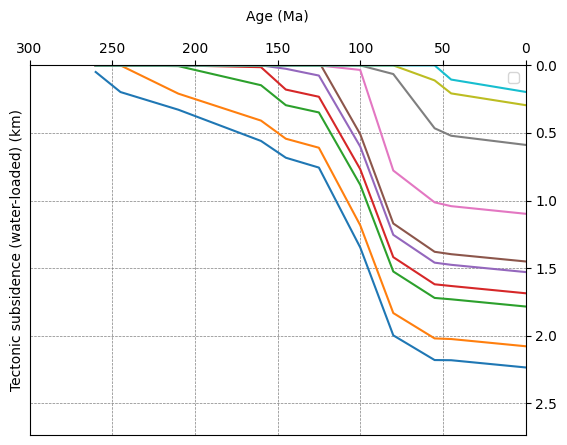

In [176]:
# work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
# age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]
age_values  = [int(age) for age in df_well['Age (Ma)'][1:]][::-1]
# age_values = list(df_well['Age (Ma)'][1:])[::-1]

# work_layers_copy = work_layers.copy()

# # Plot the lines for each row in work_layers_copy
for row_index, row in output_df.iterrows():
    plt.plot(age_values, row.values)

# # Calculate sea level and sea level today
# sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
# sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# # Fill the space between the two sea level plots with blue color
# plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
#  (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Age (Ma)', labelpad=20)
plt.ylabel(f'Tectonic subsidence (water-loaded) (km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

In [177]:

porosity_reference = pd.read_csv('/content/reference.csv', header=0)
porosity_reference

FileNotFoundError: [Errno 2] No such file or directory: '/content/reference.csv'

In [ ]:

table_mine = pd.DataFrame(porosity_df.iloc[:, 2:porosity_df.shape[1]])
table_mine = table_mine.apply(lambda x: x.astype(float))

table_ref = pd.DataFrame(porosity_reference[::-1].iloc[:, 1:porosity_reference.shape[1]])
table_ref = table_ref.apply(lambda x: x.astype(float))

# Reset the index and column labels of both dataframes
table_mine = table_mine.reset_index(drop=True)
table_ref = table_ref.reset_index(drop=True)

# Rename the columns of table_ref to match table_mine
table_ref = table_ref.rename(columns=dict(zip(table_ref.columns, table_mine.columns)))

# Perform the subtraction
result = table_mine.subtract(table_ref)*100

In [ ]:
def highlight_value(s):
    return ['background-color: red; color: white' if v < 0 else 'background-color: red; color: white' if v > 0 else '' for v in s]

styled_df = result.style.apply(highlight_value)
styled_df

### 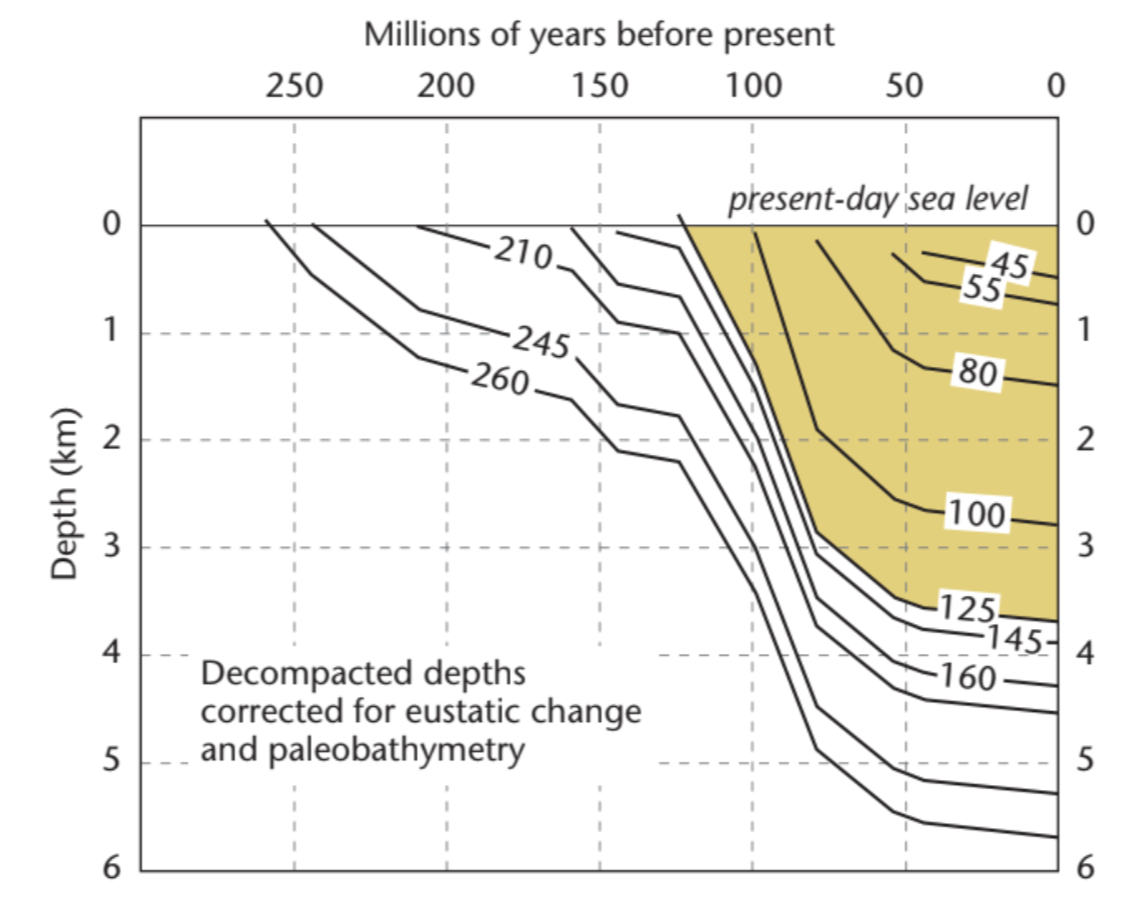Plots Age - Corrected decompacted depth

In [ ]:
work_layers = decompaction_corrected_df.drop(['Lithology_type', 'Event_name'], axis=1, inplace=False)
age_values = [int(age.split(' Ma')[0]) for age in work_layers.columns.tolist()]

work_layers_copy = work_layers.copy()

# Plot the lines for each row in work_layers_copy
for row_index, row in work_layers_copy.iterrows():
    plt.plot(age_values, row.values)

# Calculate sea level and sea level today
sea_level = df_well[1:df_well.shape[0]]['Paleobathymetry, Ma'] / 1000
sea_level_today = df_well[1:df_well.shape[0]]['Sea level, m'] / 1000

# # Plot sea level and present-day sea level
# plt.plot(age_values, (abs(sea_level - sea_level_today))[::-1], 'k--', label='Sea level')
# plt.plot(age_values, np.zeros(work_layers_copy.shape[1]), 'k--', label='present-day sea level')

# Fill the space between the two sea level plots with blue color
plt.fill_between(age_values, np.zeros(work_layers_copy.shape[1]),
 (abs(sea_level - sea_level_today))[::-1], color='blue', alpha=0.2, label='Sea level' )

# Additional plotting settings
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(work_layers_copy), -1])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Millions years before present', labelpad=20)
plt.ylabel(f'Depth(km)')
plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()

### Thermal conductivity of the basin-fill

In [ ]:
df_constast

In [ ]:
def bulk_thermal_conductivity(tc_matrix, tc_includion, porosity):
  return tc_matrix*(1-porosity) + tc_includion*porosity

Step 5. Calculation of the geotherm with variable thermal conductiv- ity: we firstly use a thermal model with a constant heat flow from the mantle, so the geotherm obeys Fourier’s law

In [ ]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
  return surface_T + (-basal_HF*depth * tc_bulk**-1)

In [ ]:
work_layers = df_well[1:df_well.shape[0]-1] ### Слои, по которым идет расчет
work_layers

In [ ]:
tc_bulk_df = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    tc_bulk_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # density_column_total = []

    RoWater, RoMantle = 1000, 3300
    tc_water = 0.60
    sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          tc_bulk = 0
          tc_bulk_list.append(tc_bulk)


### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      phi0 = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Porosity'].iloc[0]
      tc_matrix = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'TC matrix'].iloc[0]

      # c = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Exp_decay, km-1'].iloc[0]
      # RoGrain = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Grain density'].iloc[0]
      # y1 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth top, m'].iloc[0]
      # y2 = df_well.loc[df_well['Event_name'] == str(layers_name), 'Depth bottom, m'].iloc[0]

### Bulk thermal conductivity
      tc_bulk = bulk_thermal_conductivity(tc_matrix, tc_water, phi0)
      tc_bulk_list.append(tc_bulk)
      print(row_index, lithology, layers_name, phi0, np.round(bulk_thermal_conductivity(tc_matrix, tc_water, phi0), 2))


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(tc_bulk_list):] = tc_bulk_list
    new_col_values = resized_list_new
    tc_bulk_df[new_col_name] = new_col_values

In [ ]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
tc_bulk_df['Event_name'] = work_layers['Event_name']
tc_bulk_df['Lithology_type'] = work_layers['Lithology_type']
tc_bulk_df= tc_bulk_df[tc_bulk_df.columns[::-1]]

tc_bulk_df.to_csv('/content/TC_bulk.csv', index=True)

In [ ]:
tc_bulk_df

In [ ]:
decompaction_corrected_df

Step 5. Calculation of the geotherm with variable thermal conductiv-
ity: we firstly use a thermal model with a constant heat flow from the

mantle, so the geotherm obeys Fourier’s law:

In [262]:
def geotherm_constant_heat(surface_T, basal_HF, depth, tc_bulk):
    result = []
    for d, tc in zip(depth, tc_bulk):
        if np.any(tc_bulk == 0) and tc == 0:
            result.append(0)
        else:
          T = surface_T + (-basal_HF * d * 1/(tc))
          result.append(T)
    return result

In [263]:
surface_T = 0
basal_HF = -63

depth = decompaction_df.iloc[:, 2:decompaction_df.shape[1]]
tc = tc_bulk_df.iloc[:, 2:tc_bulk_df.shape[1]]

# Initialize an empty DataFrame to store the output values
geothermal_constant = pd.DataFrame()

for column_depth, column_tc in zip(depth.columns, tc.columns):
    T = geotherm_constant_heat(surface_T, basal_HF, depth[column_depth].values, tc[column_tc].values)
    geothermal_constant[column_depth] = T

In [264]:
geothermal_constant

,260,245,210,160,145,125,100,80,55,45,0
0,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.270125
1,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.305905,5.082285
2,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.039356,45.080501,42.262970
3,0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,78.057447,61.391489,59.425532,58.085106
4,0,0.000,0.000000,0.000000,0.000000,0.000000,24.496612,19.495644,18.641820,18.438529,18.296225
5,0,0.000,0.000000,0.000000,0.000000,8.513514,6.583784,5.817568,5.704054,5.704054,5.675676
6,0,0.000,0.000000,0.000000,6.849083,6.632339,6.112156,5.837615,5.794266,5.794266,5.779817
7,0,0.000,0.000000,7.969022,7.237173,6.891578,5.956438,5.285576,5.143272,5.102614,5.082285
8,0,0.000,8.075312,8.043890,8.012469,8.001995,7.939152,7.876309,7.865835,7.855362,7.855362
9,0,4.725,4.514331,4.434076,4.353822,4.303662,4.173248,4.052866,4.022771,4.022771,4.012739


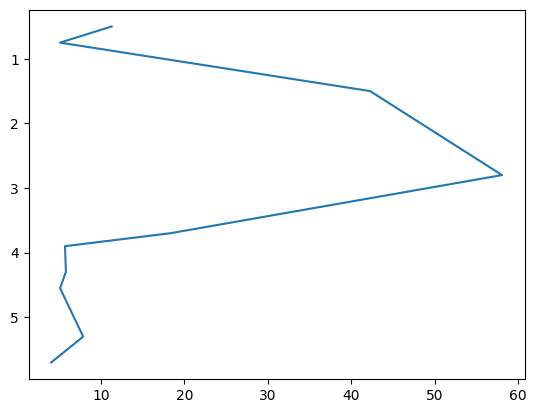

In [265]:
plt.plot(geothermal_constant['0'],decompaction_corrected_df['0'])
plt.gca().invert_yaxis()

In [214]:
tc_bulk_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.118
1,Sandstones,Layer 9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.099,3.099
2,Shales,Layer 8,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.118,1.118,1.118
3,Chalk,Layer 7,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.410,1.410,1.410,1.410
4,Sandstones,Layer 6,0.0,0.00,0.000,0.000,0.000,0.000,3.099,3.099,3.099,3.099,3.099
5,Limestones,Layer 5,0.0,0.00,0.000,0.000,0.000,2.220,2.220,2.220,2.220,2.220,2.220
6,Dolomite,Layer 4,0.0,0.00,0.000,0.000,4.360,4.360,4.360,4.360,4.360,4.360,4.360
7,Sandstones,Layer 3,0.0,0.00,0.000,3.099,3.099,3.099,3.099,3.099,3.099,3.099,3.099
8,Anhydrite,Layer 2,0.0,0.00,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015
9,Quartzite,Layer 1,0.0,6.28,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280


A58.10

In [ ]:
depth = decompaction_df.iloc[0:decompaction_df.shape[0]-1,2:decompaction_df.shape[1]]
tc = tc_bulk_df.iloc[:, 2:tc_bulk_df.shape[1]]

surface_T = 0
basal_HF = -63

new_tab = depth/tc

table2 = pd.DataFrame()
table3 = pd.DataFrame()

for col in new_tab.columns:
    cumulative_sum = new_tab[col].cumsum()
    table2[col] = surface_T+ (-basal_HF*cumulative_sum)

### проверка по глубине
for col in depth.columns:
    check_y = depth[col].cumsum
    table3[col] = depth[col].cumsum()

In [ ]:
table2

,260,245,210,160,145,125,100,80,55,45,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.270125
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.305905,16.352410
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.039356,50.386406,58.615379
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.057447,111.430845,109.811938,116.700486
4,NaN,NaN,NaN,NaN,NaN,NaN,24.496612,97.553091,130.072665,128.250466,134.996710
5,NaN,NaN,NaN,NaN,NaN,8.513514,31.080396,103.370658,135.776719,133.954521,140.672386
6,NaN,NaN,NaN,NaN,6.849083,15.145853,37.192552,109.208273,141.570985,139.748787,146.452203
7,NaN,NaN,NaN,7.969022,14.086256,22.037431,43.148989,114.493849,146.714257,144.851400,151.534487
8,NaN,NaN,8.075312,16.012913,22.098725,30.039426,51.088141,122.370158,154.580093,152.706762,159.389849
9,NaN,4.725,12.589643,20.446989,26.452546,34.343088,55.261390,126.423024,158.602864,156.729533,163.402588


In [ ]:
table3

,260,245,210,160,145,125,100,80,55,45,0
0,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.20
1,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.261,0.45
2,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.888,1.061,1.20
3,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.747,2.262,2.391,2.50
4,0.0,0.000,0.000,0.000,0.000,0.000,1.205,2.706,3.179,3.298,3.40
5,0.0,0.000,0.000,0.000,0.000,0.300,1.437,2.911,3.380,3.499,3.60
6,0.0,0.000,0.000,0.000,0.474,0.759,1.860,3.315,3.781,3.900,4.00
7,0.0,0.000,0.000,0.392,0.830,1.098,2.153,3.575,4.034,4.151,4.25
8,0.0,0.000,0.771,1.160,1.595,1.862,2.911,4.327,4.785,4.901,5.00
9,0.0,0.471,1.221,1.602,2.029,2.291,3.327,4.731,5.186,5.302,5.40


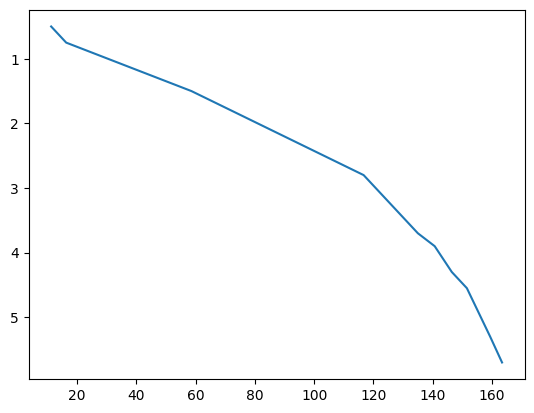

In [ ]:
plt.plot(table2['0'],decompaction_corrected_df['0'])
plt.gca().invert_yaxis()

In [266]:
df_constast

,Lithology_type,Porosity,"Exp_decay, km-1",Grain density,TC matrix,Radiogenic Heat Production,Ki_framework
0,Shales,0.63,0.51,2720,2.0,1.700000e-06,2.0
1,Sandstones,0.49,0.27,2650,5.5,1.200000e-06,5.5
2,Chalk,0.70,0.71,2710,3.3,4.000000e-07,3.3
3,Limestones,0.40,0.60,2710,3.3,5.000000e-07,3.3
4,Dolomite,0.20,0.60,2870,5.3,4.000000e-07,5.3
5,Anhydrite,0.05,0.20,2960,6.3,1.000000e-07,6.3
6,Quartzite,0.20,0.30,2650,7.7,5.000000e-07,7.7
7,Fundament,0.00,0.00,2800,3.0,2.800000e-06,3.0


In [270]:
tc_bulk_df

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.118
1,Sandstones,Layer 9,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.099,3.099
2,Shales,Layer 8,0.0,0.00,0.000,0.000,0.000,0.000,0.000,0.000,1.118,1.118,1.118
3,Chalk,Layer 7,0.0,0.00,0.000,0.000,0.000,0.000,0.000,1.410,1.410,1.410,1.410
4,Sandstones,Layer 6,0.0,0.00,0.000,0.000,0.000,0.000,3.099,3.099,3.099,3.099,3.099
5,Limestones,Layer 5,0.0,0.00,0.000,0.000,0.000,2.220,2.220,2.220,2.220,2.220,2.220
6,Dolomite,Layer 4,0.0,0.00,0.000,0.000,4.360,4.360,4.360,4.360,4.360,4.360,4.360
7,Sandstones,Layer 3,0.0,0.00,0.000,3.099,3.099,3.099,3.099,3.099,3.099,3.099,3.099
8,Anhydrite,Layer 2,0.0,0.00,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015,6.015
9,Quartzite,Layer 1,0.0,6.28,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280,6.280


Step 6. The radiogenic heat contribution: now we introduce a radio-
genic heat source to generate a more realistic geotherm. Eqn. [A58.10]


In [294]:
T_with_rad_heat = pd.DataFrame()

age_list = list(df_well['Age (Ma)'][1:])
print(age_list)

for i, age in enumerate(age_list, start=0):

    work_layers_copy = work_layers.copy()

    T_list = []

    # thinkness_list = []
    # thinkness_corrected_list = []
    # porosity_average_list = []
    # porosity_test = []
    # density_list = []
    # density_column = []
    # # density_column_total = []

    # RoWater, RoMantle = 1000, 3300
    # tc_water = 0.60
    # sea_level = df_well.loc[df_well['Age (Ma)'] == int(age), 'Paleobathymetry, Ma'].iloc[0]/1000
    # sea_level_today = df_well.loc[df_well['Age (Ma)'] == int(age), 'Sea level, m'].iloc[0]/1000
    Qm = 30
    T0 = 0

    print('Age', age)

    ### расчет corrected_decompaction for Fundament (not in work_layer)
    if int(age) == age_list[-1]:
          T = 0
          T_list.append(T)

    sum_variables_1, sum_variables_2 = [], []

### расчет для слоев с заданной литологией (work_layers)
    for row_index, row in enumerate(work_layers_copy[i::].itertuples(), start=i):

      lithology = work_layers_copy.at[row.Index, 'Lithology_type']
      layers_name = work_layers_copy.at[row.Index, 'Event_name']

      A = df_constast.loc[df_constast['Lithology_type'] == str(lithology), 'Radiogenic Heat Production'].iloc[0]
      K = tc_bulk_df.loc[tc_bulk_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      y = decompaction_corrected_df.loc[decompaction_corrected_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]
      l = decompaction_df.loc[decompaction_df['Lithology_type'] == str(lithology), f'{age}'].iloc[0]


      if K == 0:
        sum_variables_1.append(0)
        sum_variables_2.append(0)
      else:
        sum_variables_1.append((Qm+A*y)*l/K)
        sum_variables_2.append((A)*l**2/2*K)

      T = T0 + (sum(sum_variables_1) - sum(sum_variables_2))
      T_list.append(T)
      print(row_index, lithology, layers_name,y,l, K, T)


### Save results in table
    new_col_name = f'{age}'
    ### Save result for decompaction in table
    resized_list_new = np.zeros(work_layers_copy.shape[0])
    resized_list_new[len(resized_list_new) - len(T_list):] = T_list
    new_col_values = resized_list_new
    T_with_rad_heat[new_col_name] = new_col_values

[0, 45, 55, 80, 100, 125, 145, 160, 210, 245, 260]
Age 0
0 Shales Layer 10 0.4999999999999993 0.2 1.1179999999999999 5.366726411004101
1 Sandstones Layer 9 0.75 0.25 3.099 7.786861894985211
2 Shales Layer 8 0.4999999999999993 0.2 1.1179999999999999 13.153588305989311
3 Chalk Layer 7 2.8 1.3 1.4100000000000001 40.81316333011853
4 Sandstones Layer 6 0.75 0.25 3.099 43.23329881409963
5 Limestones Layer 5 3.9000000000000004 0.2 2.2199999999999998 45.93600167027802
6 Dolomite Layer 4 4.3 0.4 4.36 48.688295266537835
7 Sandstones Layer 3 0.75 0.25 3.099 51.10843075051894
8 Anhydrite Layer 2 5.299999999999999 0.75 6.015 54.849079026484226
9 Quartzite Layer 1 5.699999999999999 0.4 6.28 56.759906982290595
Age 45
1 Sandstones Layer 9 0.5290830462071514 0.261 3.099 2.5266214176110013
2 Shales Layer 8 0.26760869565217393 0.0 0.0 2.5266214176110013
3 Chalk Layer 7 2.659257053491877 1.33 1.4100000000000001 30.82449426255762
4 Sandstones Layer 6 0.5290830462071514 0.261 3.099 33.351115680168625
5 Lime

In [295]:
### добавление колонок Lithology_type,	Event_name
work_layers.reset_index(drop=True, inplace=True)
T_with_rad_heat['Event_name'] = work_layers['Event_name']
T_with_rad_heat['Lithology_type'] = work_layers['Lithology_type']
T_with_rad_heat = T_with_rad_heat[T_with_rad_heat.columns[::-1]]

T_with_rad_heat.to_csv('/content/T_with_rad_heat.csv', index=True)

In [296]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0
0,Shales,Layer 10,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.366726
1,Sandstones,Layer 9,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.526621,7.786862
2,Shales,Layer 8,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.526621,13.153588
3,Chalk,Layer 7,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,37.170213,29.234043,30.824494,40.813163
4,Sandstones,Layer 6,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,37.170213,29.234043,33.351116,43.233299
5,Limestones,Layer 5,0.0,0.00,0.000000,0.000000,0.000000,4.054054,3.135135,39.940483,31.950259,36.067332,45.936002
6,Dolomite,Layer 4,0.0,0.00,0.000000,0.000000,3.261468,7.212311,6.045686,42.720300,34.709434,38.826506,48.688295
7,Sandstones,Layer 3,0.0,0.00,0.000000,0.000000,3.261468,7.212311,6.045686,42.720300,34.709434,41.353128,51.108431
8,Anhydrite,Layer 2,0.0,0.00,3.845386,3.830424,7.076929,11.022784,9.826234,46.470923,38.455069,45.093776,54.849079
9,Quartzite,Layer 1,0.0,2.25,5.995068,5.941888,9.150177,13.072147,11.813495,48.400859,40.370675,47.009381,56.759907


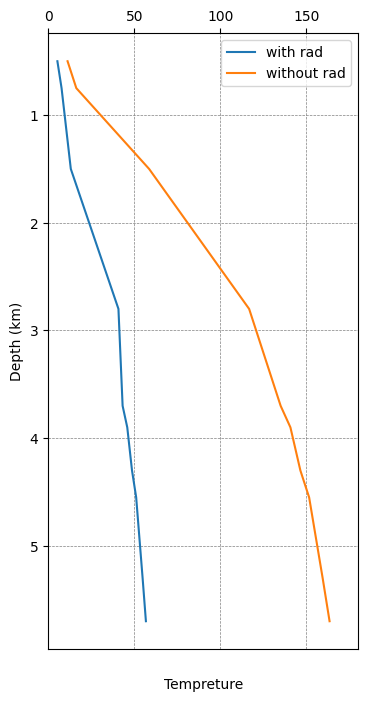

In [297]:
plt.figure(figsize=(4, 8))
plt.plot(T_with_rad_heat['0'],decompaction_corrected_df['0'], label='with rad')
plt.plot(table2['0'],decompaction_corrected_df['0'], label='without rad')
plt.gca().invert_yaxis()

# plt.axis([np.round(max(age_values), -2), np.min(age_values), np.max(output_df)+0.5, 0])

plt.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
# plt.tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)

# Move the x-axis label to the top
plt.xlabel(f'Tempreture', labelpad=20)
plt.ylabel(f'Depth (km)')
# plt.gca().xaxis.set_label_coords(0.5, 1.15)

plt.legend()
plt.grid(color='gray', linestyle='--', linewidth=0.5)

plt.xlim(0, 180)
plt.show()

In [502]:
lithology_numbers = {30000: {'lith':'Sandstones', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                 65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                 65000: {'lith':'Shales', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                 80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                 74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                 70000: {'lith':'Limestones', 'lith_num':6, 'hatch':'+', 'color':'#80ffff'},
                 70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                 88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                 86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                 99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                 90000: {'lith':'Quartzite', 'lith_num':11, 'hatch':'', 'color':'black'},
                 93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

In [503]:
T_with_rad_heat["Lithology"] = ['65000', '30000', '93000', '70032', '65030', '70000', '74000', '30000', '86000', '90000']

In [504]:
T_with_rad_heat["Lithology"] = T_with_rad_heat["Lithology"].astype(int)

In [491]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0,Lithology,depth 0
0,Shales,Layer 10,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.366726,65000,0.50
1,Sandstones,Layer 9,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.526621,7.786862,30000,0.75
2,Shales,Layer 8,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.526621,13.153588,93000,1.50
3,Chalk,Layer 7,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,37.170213,29.234043,30.824494,40.813163,70032,2.80
4,Sandstones,Layer 6,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,37.170213,29.234043,33.351116,43.233299,65030,3.70
5,Limestones,Layer 5,0.0,0.00,0.000000,0.000000,0.000000,4.054054,3.135135,39.940483,31.950259,36.067332,45.936002,70000,3.90
6,Dolomite,Layer 4,0.0,0.00,0.000000,0.000000,3.261468,7.212311,6.045686,42.720300,34.709434,38.826506,48.688295,74000,4.30
7,Sandstones,Layer 3,0.0,0.00,0.000000,0.000000,3.261468,7.212311,6.045686,42.720300,34.709434,41.353128,51.108431,30000,4.55
8,Anhydrite,Layer 2,0.0,0.00,3.845386,3.830424,7.076929,11.022784,9.826234,46.470923,38.455069,45.093776,54.849079,86000,5.30
9,Quartzite,Layer 1,0.0,2.25,5.995068,5.941888,9.150177,13.072147,11.813495,48.400859,40.370675,47.009381,56.759907,90000,5.70


In [492]:
df_lith = pd.DataFrame.from_dict(lithology_numbers, orient='index')
df_lith.index.name = 'LITHOLOGY'
df_lith

,lith,lith_num,hatch,color
LITHOLOGY,,,,
30000,Sandstones,1,..,#ffff00
65030,Sandstone/Shale,2,-.,#ffe119
65000,Shales,3,--,#bebebe
80000,Marl,4,,#7cfc00
74000,Dolomite,5,-/,#8080ff
70000,Limestones,6,+,#80ffff
70032,Chalk,7,..,#80ffff
88000,Halite,8,x,#7ddfbe
86000,Anhydrite,9,,#ff80ff


In [493]:
T_with_rad_heat["Lithology_type"]

0        Shales
1    Sandstones
2        Shales
3         Chalk
4    Sandstones
5    Limestones
6      Dolomite
7    Sandstones
8     Anhydrite
9     Quartzite
Name: Lithology_type, dtype: object

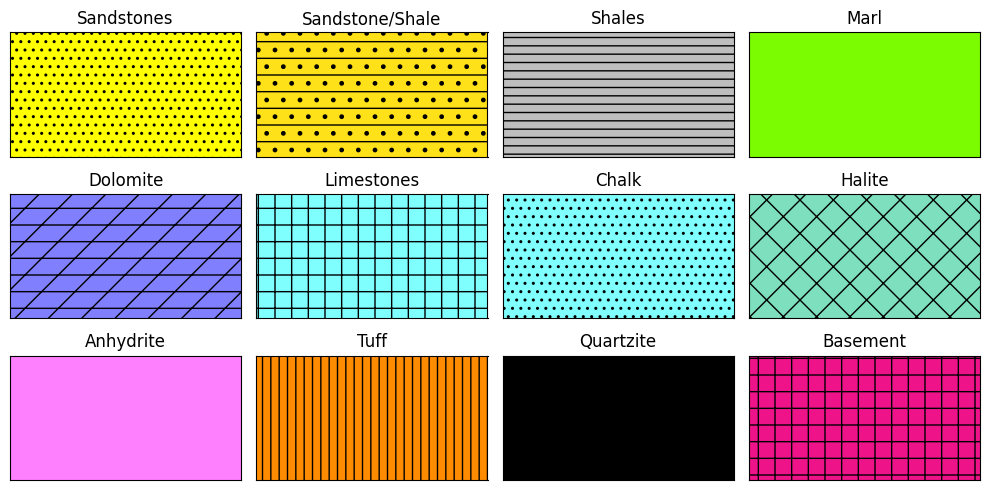

In [494]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()

plt.show()

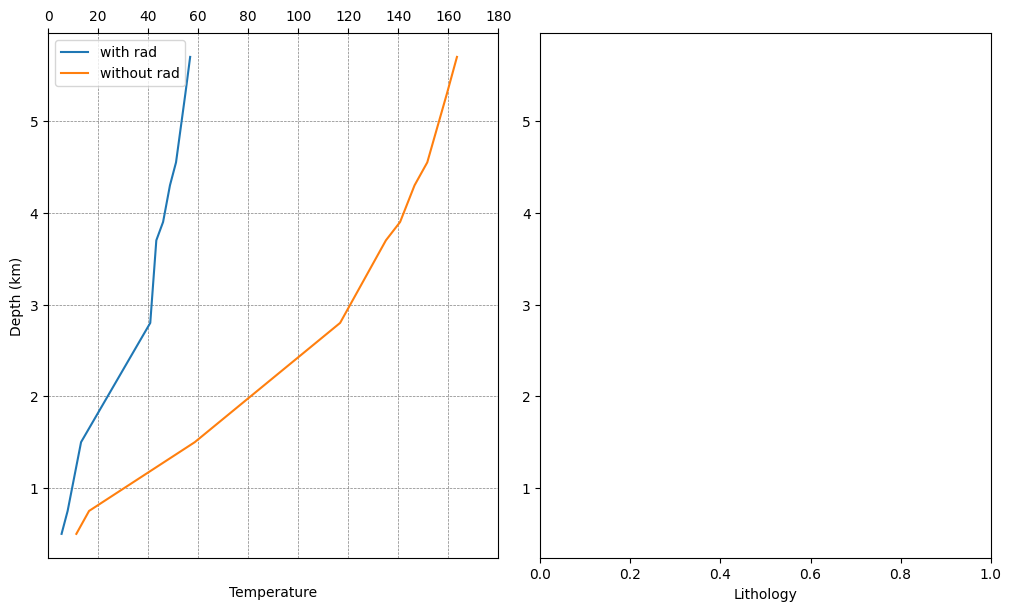

In [495]:
fig = plt.figure(constrained_layout=True, figsize=(10, 6))
ax = fig.subplots(1, 2,  sharex=False)

ax[0].plot(T_with_rad_heat['0'], decompaction_corrected_df['0'], label='with rad')
ax[0].plot(table2['0'], decompaction_corrected_df['0'], label='without rad')
# ax[0].invert_yaxis()
ax[0].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
ax[0].set_xlabel('Temperature', labelpad=20)
ax[0].set_ylabel('Depth (km)')
ax[0].legend()
ax[0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0].set_xlim(0, 180)


 #Lithology track
ax[1].plot(T_with_rad_heat["Lithology"], decompaction_corrected_df['0'], color = "black", linewidth = 0.5)
ax[1].set_xlabel("Lithology")
ax[1].set_xlim(0, 1)
# ax[1].xaxis.label.set_color("black")
# ax[1].tick_params(axis='x', colors="black")
# ax[1].spines["top"].set_edgecolor("black")

# for key in lithology_numbers.keys():
#     color = lithology_numbers[key]['color']
#     hatch = lithology_numbers[key]['hatch']
#     ax[1].fill_betweenx(decompaction_corrected_df['0'], 0, T_with_rad_heat["Lithology_type"], where=(T_with_rad_heat["Lithology_type"]==key),
#                       facecolor=color, hatch=hatch)


    # ax[1].set_xticks([0, 1])

plt.show()

In [496]:
T_with_rad_heat['depth 0'] = decompaction_corrected_df['0']

In [497]:
T_with_rad_heat

,Lithology_type,Event_name,260,245,210,160,145,125,100,80,55,45,0,Lithology,depth 0
0,Shales,Layer 10,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.366726,65000,0.50
1,Sandstones,Layer 9,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.526621,7.786862,30000,0.75
2,Shales,Layer 8,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.526621,13.153588,93000,1.50
3,Chalk,Layer 7,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,37.170213,29.234043,30.824494,40.813163,70032,2.80
4,Sandstones,Layer 6,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,37.170213,29.234043,33.351116,43.233299,65030,3.70
5,Limestones,Layer 5,0.0,0.00,0.000000,0.000000,0.000000,4.054054,3.135135,39.940483,31.950259,36.067332,45.936002,70000,3.90
6,Dolomite,Layer 4,0.0,0.00,0.000000,0.000000,3.261468,7.212311,6.045686,42.720300,34.709434,38.826506,48.688295,74000,4.30
7,Sandstones,Layer 3,0.0,0.00,0.000000,0.000000,3.261468,7.212311,6.045686,42.720300,34.709434,41.353128,51.108431,30000,4.55
8,Anhydrite,Layer 2,0.0,0.00,3.845386,3.830424,7.076929,11.022784,9.826234,46.470923,38.455069,45.093776,54.849079,86000,5.30
9,Quartzite,Layer 1,0.0,2.25,5.995068,5.941888,9.150177,13.072147,11.813495,48.400859,40.370675,47.009381,56.759907,90000,5.70


In [518]:
T_with_rad_heat.loc[T_with_rad_heat['Lithology'] == 65000, 'depth 0']

0    0.5
Name: depth 0, dtype: float64

In [564]:

def makeplot(well, top_depth, bottom_depth):
    fig, ax = plt.subplots(figsize=(8,6))

    #Set up the plot axes
    ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
    ax4 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)

    # As our curve scales will be detached from the top of the track,
    # this code adds the top border back in without dealing with splines
    # ax10 = ax1.twiny()
    # ax10.xaxis.set_visible(False)

    # ax13 = ax4.twiny()
    # ax13.xaxis.set_visible(False)

    # Gamma Ray track
    ax1.plot(T_with_rad_heat['0'], decompaction_corrected_df['0'], label='with rad')

    # Lithology track
    ax4.plot(T_with_rad_heat["Lithology"], decompaction_corrected_df['0'], color = "black", linewidth = 0.5)
    ax4.set_xlabel("Lithology")
    ax4.set_xlim(0, 1)
    ax4.xaxis.label.set_color("black")
    ax4.tick_params(axis='x', colors="black")
    ax4.spines["top"].set_edgecolor("black")
    ax4.set_xticks([0, 1])

    # Python

    unique_lithologies = T_with_rad_heat['Lithology'].unique()

    for key in unique_lithologies:
      color = lithology_numbers[key]['color']
      hatch = lithology_numbers[key]['hatch']

      # Create an array of depth values with the same size as the y array
      depth_values = T_with_rad_heat.loc[T_with_rad_heat['Lithology'] == int(key), 'depth 0']
      lit = T_with_rad_heat.loc[T_with_rad_heat['Lithology'] == int(key), 'Lithology']
      if len(lit) != 1:
        lit = T_with_rad_heat.loc[T_with_rad_heat['Lithology'] == int(key), 'Lithology'].iloc[0]
        depth_values = T_with_rad_heat.loc[T_with_rad_heat['Lithology'] == int(key), 'depth 0'].iloc[0]
      else:
        pass

      print(depth_values, lit)
      ax4.fill_betweenx(depth_values, 0, 1,
                        facecolor=color, hatch=hatch, where=(lit == key))


    # for depth_value in unique_depth_values:
    #     for key in T_with_rad_heat.loc[T_with_rad_heat['depth 0'] == depth_value, 'Lithology']:
    #         color = lithology_numbers[key]['color']
    #         hatch = lithology_numbers[key]['hatch']

    #         where_condition = T_with_rad_heat['Lithology'] == key
    #         y_values = T_with_rad_heat.loc[where_condition, 'depth 0'].values()  # Get the depth values where the condition is True

    #         ax4.fill_betweenx(y_values, 0, 1, facecolor=color, hatch=hatch, where=where_condition)

    # Common functions for setting up the plot can be extracted into
    # a for loop. This saves repeating code.
    for ax in [ax1, ax4]:
        ax.set_ylim(bottom_depth, top_depth)
        ax.grid(which='major', color='lightgrey', linestyle='-')
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_label_position("top")
        ax.spines["top"].set_position(("axes", 1.02))


    for ax in [ax4]:
        plt.setp(ax.get_yticklabels(), visible = True)

    plt.tight_layout()
    fig.subplots_adjust(wspace = 0.15)

0    0.5
Name: depth 0, dtype: float64 0    65000
Name: Lithology, dtype: int64
0.75 30000


<ipython-input-564-2b6358dd47d7>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

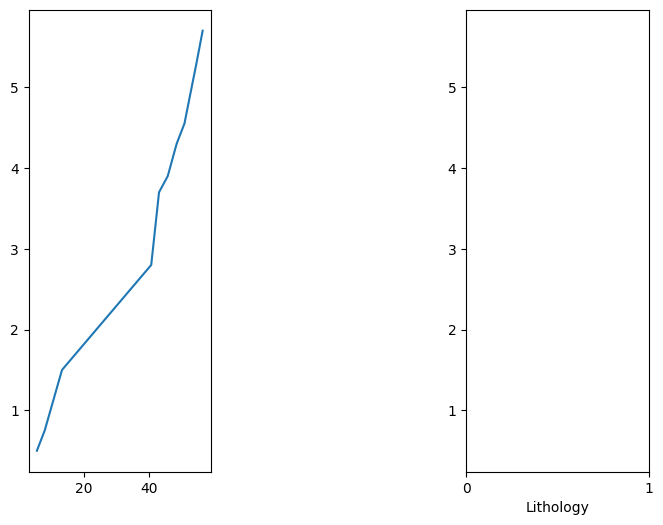

In [565]:
makeplot(T_with_rad_heat, 0, 5)

In [499]:
#